<a href="https://colab.research.google.com/github/hmahmuda/AtmoSense-AQI-/blob/main/Atmo_Sense(AQI).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AtmoSense: Air Quality Prediction System**
**Mahmuda sultana(231-115-018)**

# **Phase 1: Setup & Initialization**

**Cell 1: Install Required Libraries**

In [ ]:
#@title 📦 Install Required Libraries
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm catboost plotly missingno -q
!pip install prophet statsmodels shap watermark -q

**Cell 2: Import All Libraries**

In [ ]:
#@title 📚 Import All Necessary Libraries
# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import missingno as msno

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Advanced
import shap
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Magic commands for Colab
%matplotlib inline

**Cell 3: Mount Google Drive & Load Dataset**

In [ ]:
#@title 🚀 Mount Google Drive and Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/AtmoSense/AirQualityUCI.csv')


print("✅ Dataset loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")

Mounted at /content/drive
✅ Dataset loaded successfully!
📊 Dataset shape: (9471, 17)


# **Phase 2: Data Exploration & Understanding (EDA)**

**Cell 4: Data Inspection**

In [ ]:
#@title 📊 Basic Data Inspection
print("\n📅 First 5 rows:")
#removing the last 2 columns from the dataframe as they are empty
df = df.iloc[:, :-2]
display(df.head())
df.head()
# Keeping only first 9357 rows as in original
df = df.head(9357)
print(f"\n📋Last 5 rows:")
df.tail()


📅 First 5 rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888



📋Last 5 rows:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,4/4/2005,10:00:00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,4/4/2005,11:00:00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,4/4/2005,12:00:00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,4/4/2005,13:00:00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139
9356,4/4/2005,14:00:00,2.2,1071.0,-200.0,11.9,1047.0,265.0,654.0,168.0,1129.0,816.0,28.5,13.1,0.5028


**Cell 5: Missing Value Analysis**

In [ ]:
import matplotlib.pyplot as plt
import missingno as msno

#@title 🕵️ Missing Value Analysis
print("="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

# Calculate missing values
missing_data = pd.DataFrame({
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100,
    'Data_Type': df.dtypes
}).sort_values('Missing_Percentage', ascending=False)

print("\n📊 Missing Value Statistics:")
display(missing_data[missing_data['Missing_Count'] > 0])

# Check if there are any columns with missing values before plotting
if (missing_data['Missing_Count'] > 0).any():
    print("\nVisualizing missing values:")
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))

    # Bar plot
    missing_data[missing_data['Missing_Percentage'] > 0]['Missing_Percentage'].plot(
        kind='bar', ax=axes[0], color='coral')
    axes[0].set_title('Missing Values Percentage by Column')
    axes[0].set_ylabel('Percentage')
    axes[0].tick_params(axis='x', rotation=45)

    # Heatmap
    msno.matrix(df, ax=axes[1])
    axes[1].set_title('Missing Values Matrix')

    # Heatmap of nullity correlation
    msno.heatmap(df, ax=axes[2])
    axes[2].set_title('Missing Values Correlation Heatmap')

    plt.tight_layout()
    plt.show()
else:
    print("\n✅ No missing values found in the dataset.")
    plt.close() # Close any potentially created empty figure to avoid displaying it

# Summary statistics
print("\n📈 Dataset Summary Statistics:")
display(df.describe())

MISSING VALUE ANALYSIS

📊 Missing Value Statistics:


,Missing_Count,Missing_Percentage,Data_Type



✅ No missing values found in the dataset.

📈 Dataset Summary Statistics:


,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604
std,77.657170,329.832710,139.789093,41.380206,342.333252,257.433866,321.993552,126.940455,467.210125,456.938184,43.203623,51.216145,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300
50%,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800
75%,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200
max,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000


**Cell 6: Advanced EDA with Visualizations**

EXPLORATORY DATA ANALYSIS WITH INTERACTIVE VISUALIZATIONS
✅ Created DateTime column. Dataset now has 9357 rows after cleaning.

📈 Interactive Time Series Analysis (Select pollutants to visualize):

🔍 Detected Pollutant Columns: ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'WeekOfYear', 'IsWeekend', 'Season']



🔥 Correlation Matrix of Pollutants:



📊 Distribution of Pollutants:


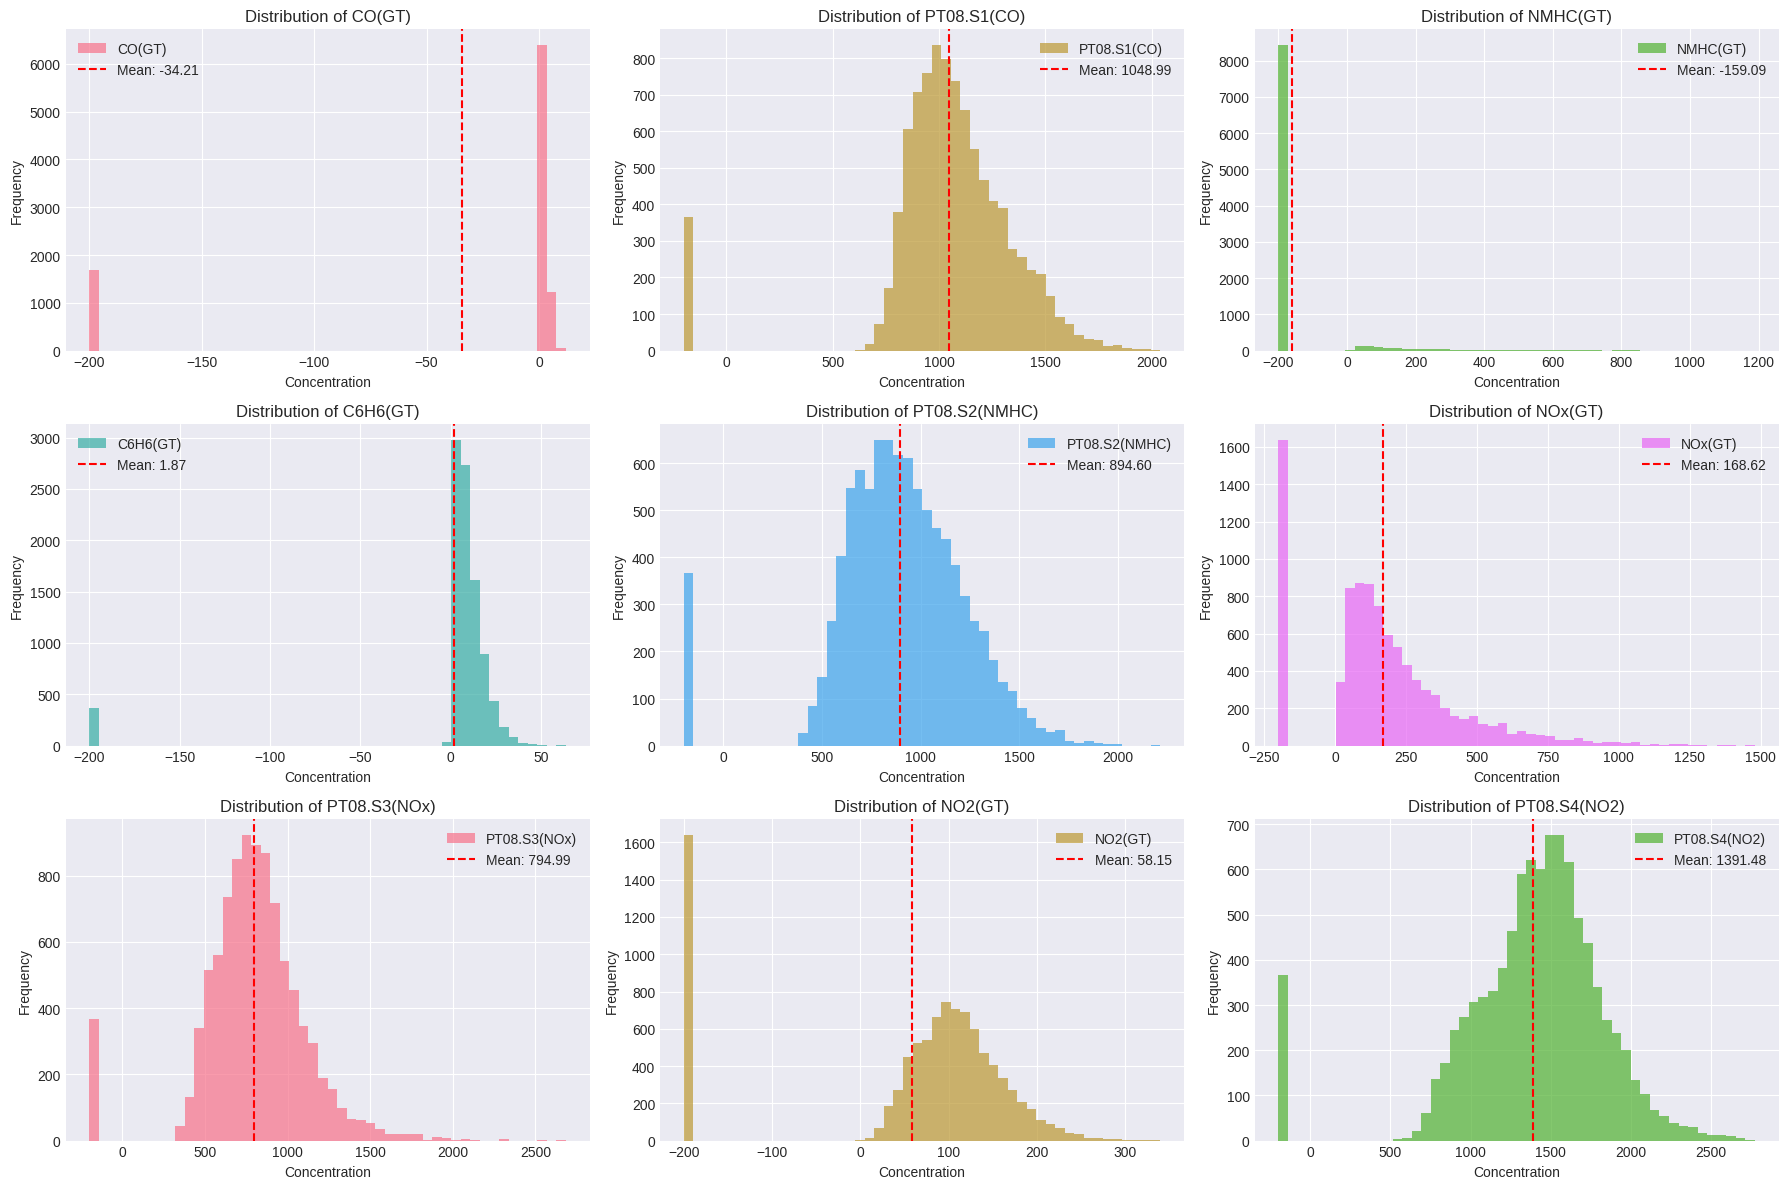


📦 Box Plots for Outlier Detection:


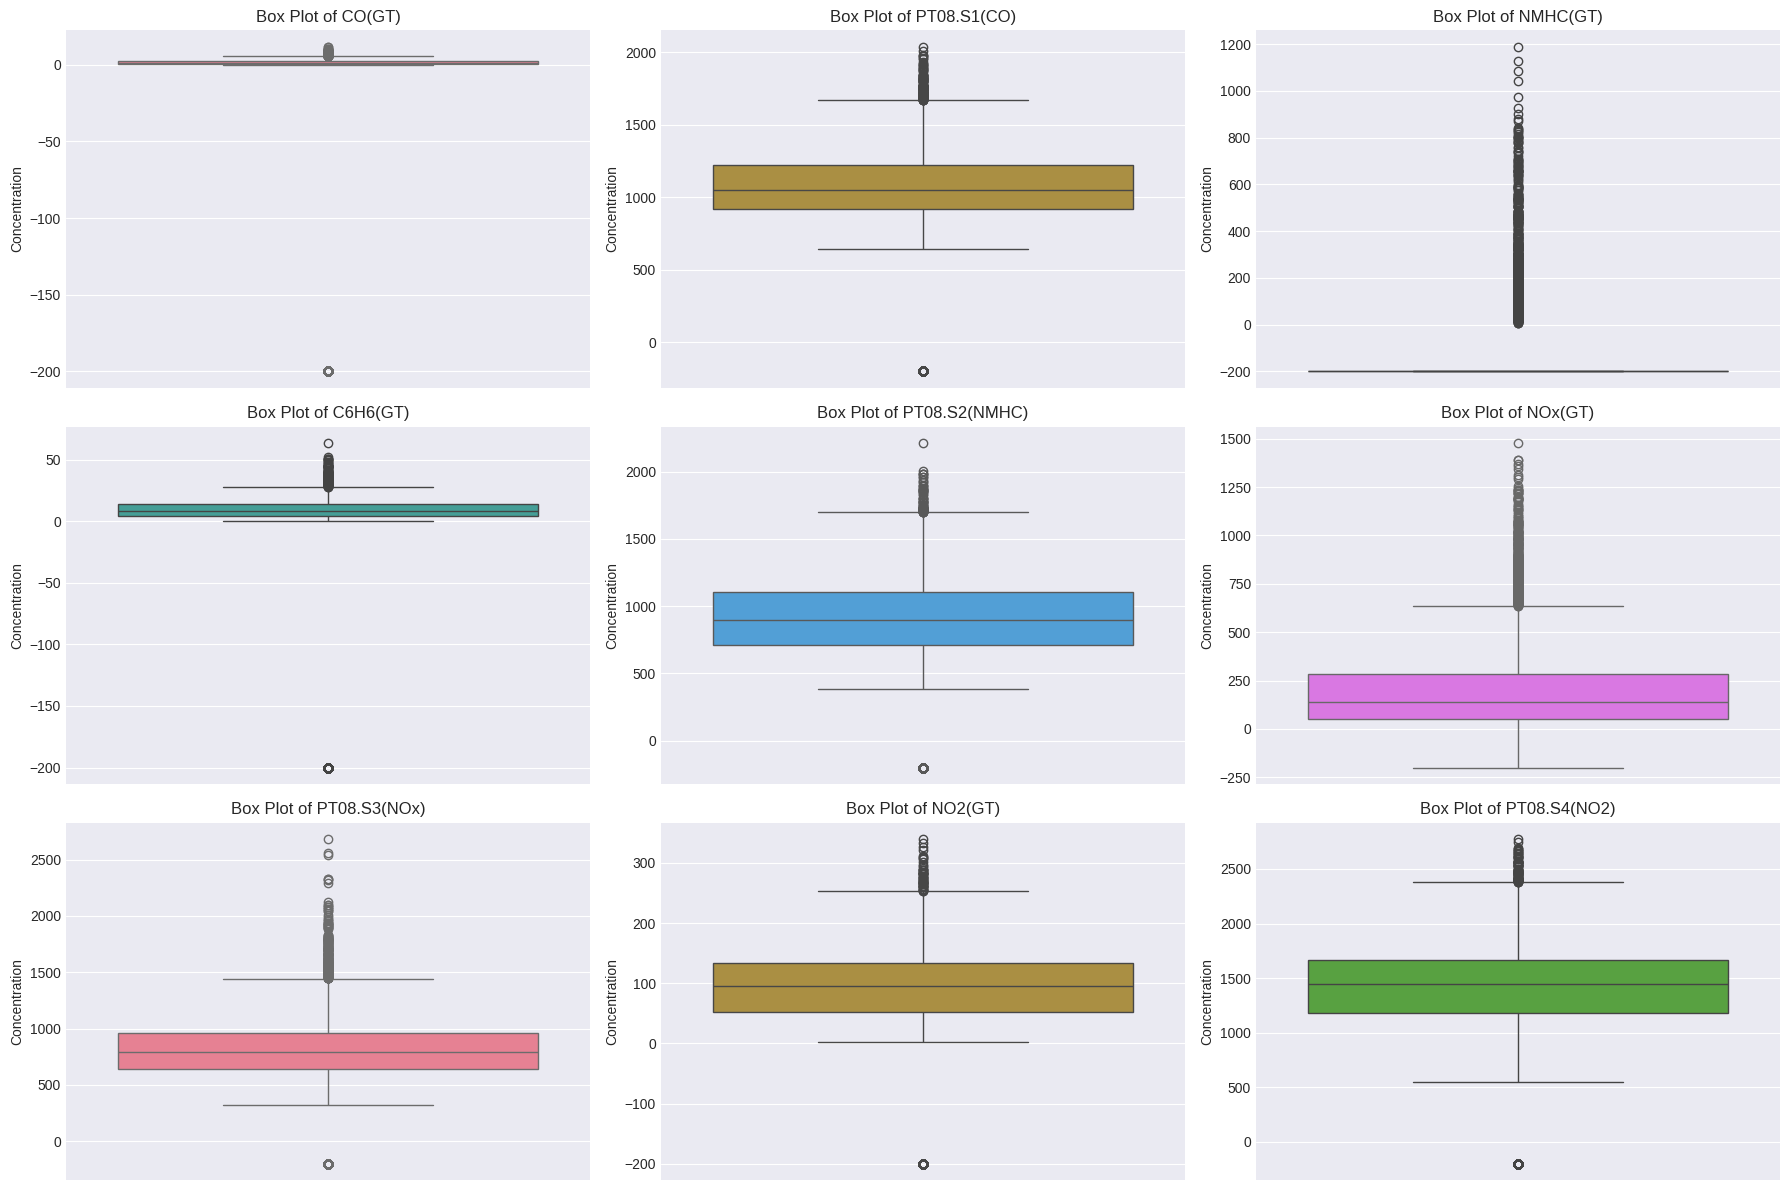

In [ ]:
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#@title 📊 Advanced EDA with Interactive Visualizations
print("="*80)
print("EXPLORATORY DATA ANALYSIS WITH INTERACTIVE VISUALIZATIONS")
print("="*80)

# Create a copy for EDA
eda_df = df.copy()

# Convert date and time columns
if 'Date' in eda_df.columns and 'Time' in eda_df.columns:
    # Remove rows where Date or Time might be problematic
    eda_df = eda_df[eda_df['Date'].notna() & eda_df['Time'].notna()]

    # Create datetime column
    eda_df['DateTime'] = pd.to_datetime(eda_df['Date'].astype(str) + ' ' + eda_df['Time'].astype(str),
                                       errors='coerce')

    print(f"✅ Created DateTime column. Dataset now has {eda_df.shape[0]} rows after cleaning.")

    # Set datetime as index
    eda_df.set_index('DateTime', inplace=True)

    # Extract temporal features
    eda_df['Year'] = eda_df.index.year
    eda_df['Month'] = eda_df.index.month
    eda_df['Day'] = eda_df.index.day
    eda_df['Hour'] = eda_df.index.hour
    eda_df['DayOfWeek'] = eda_df.index.dayofweek
    eda_df['WeekOfYear'] = eda_df.index.isocalendar().week
    eda_df['IsWeekend'] = (eda_df['DayOfWeek'] >= 5).astype(int)
    eda_df['Season'] = eda_df['Month'].apply(lambda x: (x%12 + 3)//3)

# Interactive time series plot for all pollutants
print("\n📈 Interactive Time Series Analysis (Select pollutants to visualize):")

# Identify numeric columns (pollutants)
numeric_cols = eda_df.select_dtypes(include=[np.number]).columns.tolist()
pollutants = [col for col in numeric_cols if 'Unnamed' not in str(col)]

print(f"\n🔍 Detected Pollutant Columns: {pollutants}")

# Create interactive time series plot
fig = go.Figure()

for i, pollutant in enumerate(pollutants[:6]):  # Limit to first 6 for clarity
    if pollutant in eda_df.columns:
        fig.add_trace(go.Scatter(
            x=eda_df.index,
            y=eda_df[pollutant],
            mode='lines',
            name=pollutant,
            opacity=0.7,
            visible=True if i < 3 else 'legendonly'  # Show first 3 by default
        ))

fig.update_layout(
    title='📊 Time Series of Air Pollutants',
    xaxis_title='Date',
    yaxis_title='Concentration',
    height=600,
    hovermode='x unified',
    template='plotly_white'
)

fig.show()

# Correlation matrix with heatmap
print("\n🔥 Correlation Matrix of Pollutants:")

# Calculate correlation
correlation_matrix = eda_df[pollutants].corr()

fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.columns,
    colorscale='RdBu',
    zmid=0,
    text=correlation_matrix.round(2).values,
    texttemplate='%{text}',
    textfont={"size": 10},
    hoverongaps=False
))

fig.update_layout(
    title='Heatmap of Pollutant Correlations',
    height=600,
    width=700,
    xaxis_tickangle=-45
)

fig.show()

# Distribution plots
print("\n📊 Distribution of Pollutants:")

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutants[:9]):
    if idx < len(axes):
        ax = axes[idx]
        eda_df[pollutant].plot(kind='hist', bins=50, ax=ax, alpha=0.7, color=f'C{idx}')
        ax.set_title(f'Distribution of {pollutant}')
        ax.set_xlabel('Concentration')
        ax.set_ylabel('Frequency')

        # Add vertical line for mean
        ax.axvline(eda_df[pollutant].mean(), color='red', linestyle='--', label=f'Mean: {eda_df[pollutant].mean():.2f}')
        ax.legend()

plt.tight_layout()
plt.show()

# Box plots for outlier detection
print("\n📦 Box Plots for Outlier Detection:")

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, pollutant in enumerate(pollutants[:9]):
    if idx < len(axes):
        ax = axes[idx]
        sns.boxplot(data=eda_df, y=pollutant, ax=ax, color=f'C{idx}')
        ax.set_title(f'Box Plot of {pollutant}')
        ax.set_ylabel('Concentration')

plt.tight_layout()
plt.show()


# **Phase 3: Data Cleaning**

**Cell 7: Advanced Data Cleaning**

In [ ]:
from sklearn.impute import KNNImputer

#@title 🧹 Advanced Data Cleaning Pipeline
print("="*80)
print("ADVANCED DATA CLEANING PIPELINE")
print("="*80)

# Create a copy for cleaning
clean_df = df.copy()

print(f"📊 Original dataset shape: {clean_df.shape}")

# Step 1: Handle comma as decimal separator
print("\n1️⃣ Converting comma to decimal points...")
for col in clean_df.columns:
    if clean_df[col].dtype == 'object':
        # Try to convert strings with commas to floats
        try:
            clean_df[col] = clean_df[col].str.replace(',', '.').astype(float)
            print(f"   Converted {col} to float")
        except:
            pass

# Step 2: Create datetime index
print("\n2️⃣ Creating datetime index...")
if 'Date' in clean_df.columns and 'Time' in clean_df.columns:
    # Clean Date and Time columns
    # Assuming 'Date' is dd/mm/yyyy format based on typical European datasets
    clean_df['Date'] = pd.to_datetime(clean_df['Date'], format='%d/%m/%Y', errors='coerce')
    clean_df['Time'] = pd.to_datetime(clean_df['Time'], format='%H:%M:%S', errors='coerce').dt.time

    # Combine date and time
    # Filter out rows where date or time conversion failed to avoid NaT in DateTime
    clean_df = clean_df.dropna(subset=['Date', 'Time']).copy() # Added .copy() to avoid SettingWithCopyWarning
    clean_df['DateTime'] = pd.to_datetime(
        clean_df['Date'].astype(str) + ' ' + clean_df['Time'].astype(str),
        errors='coerce'
    )

    # Set as index and drop original columns
    clean_df.set_index('DateTime', inplace=True)
    clean_df.drop(['Date', 'Time'], axis=1, inplace=True, errors='ignore')

    print(f"   Created DateTime index. Rows with valid datetime: {clean_df.index.notna().sum()}")

# Step 3: Handle missing values with advanced imputation
print("\n3️⃣ Handling missing values...")

# Drop columns with more than 40% missing values
threshold = 0.4
cols_to_drop = []
for col in clean_df.columns:
    missing_percentage = clean_df[col].isnull().mean()
    if missing_percentage > threshold:
        cols_to_drop.append(col)
        print(f"   Dropping {col}: {missing_percentage*100:.1f}% missing")

if cols_to_drop:
    clean_df.drop(cols_to_drop, axis=1, inplace=True)

# Identify numeric columns for imputation
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns

print(f"\n4️⃣ Performing advanced imputation on {len(numeric_cols)} numeric columns...")

# Use KNN Imputer for better results
imputer = KNNImputer(n_neighbors=5, weights='distance')
clean_df[numeric_cols] = imputer.fit_transform(clean_df[numeric_cols])

print("   KNN Imputation completed!")

# Step 4: Handle outliers using IQR method
print("\n5️⃣ Handling outliers using IQR method...")

def handle_outliers_iqr(df, columns):
    df_clean = df.copy()
    outlier_info = {}

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers
        outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        outlier_count = len(outliers)

        # Cap outliers
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

        outlier_info[col] = {
            'outlier_count': outlier_count,
            'percentage': (outlier_count / len(df_clean)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound
        }

    return df_clean, outlier_info

clean_df, outlier_info = handle_outliers_iqr(clean_df, numeric_cols)

# Display outlier information
outlier_summary = pd.DataFrame(outlier_info).T
print("\n   Outlier Summary:")
display(outlier_summary[['outlier_count', 'percentage']].sort_values('percentage', ascending=False))

# Step 5: Create temporal features
print("\n6️⃣ Creating advanced temporal features...")

# Ensure the index is a DatetimeIndex before creating temporal features
if not isinstance(clean_df.index, pd.DatetimeIndex):
    print("   Warning: DateTime index is not set correctly. Skipping temporal feature creation.")
else:
    clean_df['Year'] = clean_df.index.year
    clean_df['Month'] = clean_df.index.month
    clean_df['Day'] = clean_df.index.day
    clean_df['Hour'] = clean_df.index.hour
    clean_df['DayOfWeek'] = clean_df.index.dayofweek
    clean_df['DayOfYear'] = clean_df.index.dayofyear
    clean_df['WeekOfYear'] = clean_df.index.isocalendar().week.astype(int) # Ensure int type
    clean_df['Quarter'] = clean_df.index.quarter

    # Cyclical encoding for time features
    clean_df['Hour_sin'] = np.sin(2 * np.pi * clean_df['Hour']/24)
    clean_df['Hour_cos'] = np.cos(2 * np.pi * clean_df['Hour']/24)
    clean_df['Month_sin'] = np.sin(2 * np.pi * clean_df['Month']/12)
    clean_df['Month_cos'] = np.cos(2 * np.pi * clean_df['Month']/12)

    # Create season feature
    clean_df['Season'] = clean_df['Month'].apply(lambda x: (x%12 + 3)//3)

    # Create time-based features
    clean_df['IsWeekend'] = (clean_df['DayOfWeek'] >= 5).astype(int)
    clean_df['IsWorkingHour'] = ((clean_df['Hour'] >= 8) & (clean_df['Hour'] <= 18)).astype(int)
    clean_df['IsNight'] = ((clean_df['Hour'] >= 22) | (clean_df['Hour'] <= 6)).astype(int)

    print(f"   Created {len([col for col in clean_df.columns if col not in numeric_cols])} new temporal features")

# Step 6: Final dataset information
print("\n" + "="*50)
print("CLEANING SUMMARY")
print("="*50)
print(f"✅ Original shape: {df.shape}")
print(f"✅ Cleaned shape: {clean_df.shape}")
print(f"✅ Remaining missing values: {clean_df.isnull().sum().sum()}")
print(f"✅ Numeric columns: {len(numeric_cols)}")
print(f"✅ Total features after engineering: {len(clean_df.columns)}")
print("="*50)

# Display cleaned dataset info
print("\n📋 Cleaned Dataset Info:")
print(clean_df.info())

print("\n👀 First 5 rows of cleaned data:")
display(clean_df.head())

ADVANCED DATA CLEANING PIPELINE
📊 Original dataset shape: (9357, 15)

1️⃣ Converting comma to decimal points...

2️⃣ Creating datetime index...
   Created DateTime index. Rows with valid datetime: 3597

3️⃣ Handling missing values...

4️⃣ Performing advanced imputation on 13 numeric columns...
   KNN Imputation completed!

5️⃣ Handling outliers using IQR method...

   Outlier Summary:


,outlier_count,percentage
NO2(GT),711.0,19.766472
CO(GT),662.0,18.404226
NMHC(GT),294.0,8.173478
PT08.S3(NOx),274.0,7.617459
C6H6(GT),266.0,7.395051
PT08.S1(CO),222.0,6.171810
PT08.S5(O3),211.0,5.865999
PT08.S4(NO2),205.0,5.699194
PT08.S2(NMHC),203.0,5.643592
RH,179.0,4.976369



6️⃣ Creating advanced temporal features...
   Created 16 new temporal features

CLEANING SUMMARY
✅ Original shape: (9357, 15)
✅ Cleaned shape: (3597, 29)
✅ Remaining missing values: 0
✅ Numeric columns: 13
✅ Total features after engineering: 29

📋 Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3597 entries, 2004-10-03 18:00:00 to 2005-04-04 14:00:00
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         3597 non-null   float64
 1   PT08.S1(CO)    3597 non-null   float64
 2   NMHC(GT)       3597 non-null   float64
 3   C6H6(GT)       3597 non-null   float64
 4   PT08.S2(NMHC)  3597 non-null   float64
 5   NOx(GT)        3597 non-null   float64
 6   PT08.S3(NOx)   3597 non-null   float64
 7   NO2(GT)        3597 non-null   float64
 8   PT08.S4(NO2)   3597 non-null   float64
 9   PT08.S5(O3)    3597 non-null   float64
 10  T              3597 non-null   float64
 11  RH       

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Year,Month,Day,Hour,DayOfWeek,DayOfYear,WeekOfYear,Quarter,Hour_sin,Hour_cos,Month_sin,Month_cos,Season,IsWeekend,IsWorkingHour,IsNight
DateTime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-10-03 18:00:00,2.6,1360.0,-200.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004,10,3,18,6,277,40,4,-1.000000,-1.836970e-16,-0.866025,0.5,4,1,1,0
2004-10-03 19:00:00,2.0,1292.0,-200.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004,10,3,19,6,277,40,4,-0.965926,2.588190e-01,-0.866025,0.5,4,1,0,0
2004-10-03 20:00:00,2.2,1402.0,-200.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004,10,3,20,6,277,40,4,-0.866025,5.000000e-01,-0.866025,0.5,4,1,0,0
2004-10-03 21:00:00,2.2,1376.0,-200.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004,10,3,21,6,277,40,4,-0.707107,7.071068e-01,-0.866025,0.5,4,1,0,0
2004-10-03 22:00:00,1.6,1272.0,-200.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004,10,3,22,6,277,40,4,-0.500000,8.660254e-01,-0.866025,0.5,4,1,0,1


# **Phase 4: DATA PREPROCESSING**

**Cell 8: Feature Engineering and Preparation**

In [ ]:
# Define target variables
# For Regression: Predict CO(GT)
# For Classification: Create categories based on CO levels


# Ensure we are using the most recently cleaned dataframe
df_processed = clean_df.copy()


# Create classification target (Air Quality Categories)
df_processed['CO_Category'] = pd.cut(df_processed['CO(GT)'],
                                   bins=[-float('inf'), 1, 3, float('inf')],
                                   labels=['Good', 'Moderate', 'Bad'])


print("🎯 Target Categories Distribution:")
print(df_processed['CO_Category'].value_counts())


# Prepare features for both regression and classification
features = [col for col in df_processed.columns if col not in ['CO(GT)', 'CO_Category']]
X = df_processed[features]


# For Regression
y_reg = df_processed['CO(GT)']


# For Classification
y_clf = df_processed['CO_Category']


# Split data for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)


# Split data for classification
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


# Scale features
scaler = StandardScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)
X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)


print(f"\n✅ Data prepared successfully!")
print(f"Training samples: {X_train_reg.shape[0]}")
print(f"Testing samples: {X_test_reg.shape[0]}")
print(f"Features: {X_train_reg.shape[1]}")

🎯 Target Categories Distribution:
CO_Category
Moderate    1660
Good        1294
Bad          643
Name: count, dtype: int64

✅ Data prepared successfully!
Training samples: 2877
Testing samples: 720
Features: 28


# PHASE 5: REGRESSION MODELS

**Cell 9: Linear Regression (Scikit-learn)**

📈 LINEAR REGRESSION IMPLEMENTATION

🎯 LINEAR REGRESSION RESULTS:
Mean Squared Error: 1.1394
R² Score: 0.7026
Coefficients: [ 2.85470423e-03 -2.93098879e-14  1.22348407e+00 -1.22601379e+00
  1.15611530e+00 -2.94040377e-01  3.13270148e-01  4.03986504e-01
 -9.48537027e-02  4.86923224e-01  2.17753612e-01 -7.75290678e-01
 -2.49295022e-01 -1.55855948e+01 -6.06015513e-01 -6.29980093e-02
  1.87697940e-01  1.51131842e+01  6.86900304e-02  3.48809255e-01
 -4.53784499e-02  3.17655903e-01 -2.65253763e-01 -8.28922906e-02
 -1.33974035e-01 -2.17602555e-01  5.32936174e-02 -9.77055698e-02]
Intercept: 1.3741


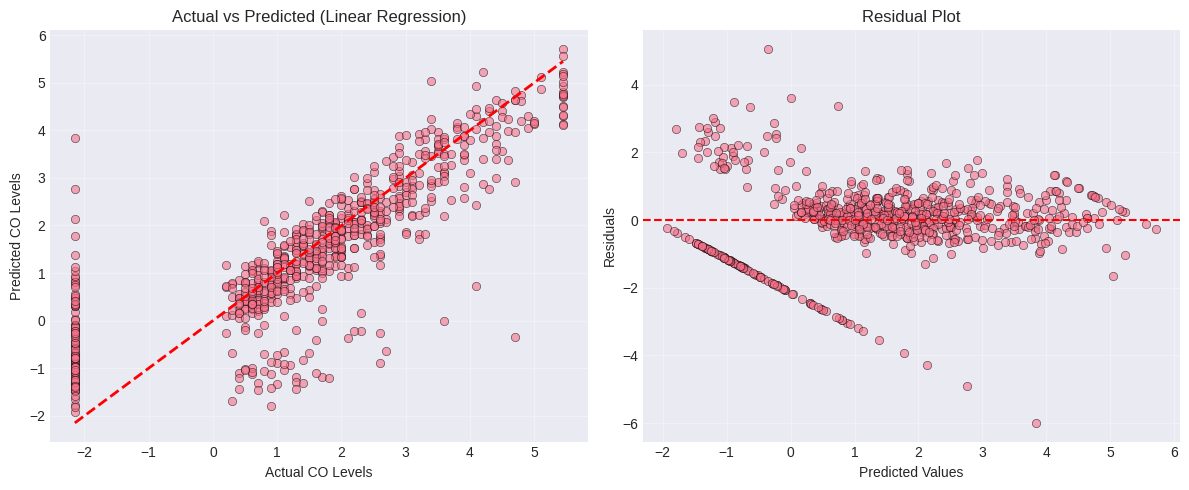

In [ ]:
print("="*60)
print("📈 LINEAR REGRESSION IMPLEMENTATION")
print("="*60)

# Using Scikit-learn's Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_reg_scaled, y_train_reg)

# Predictions
y_pred_lr = lr_model.predict(X_test_reg_scaled)

# Evaluation
mse_lr = mean_squared_error(y_test_reg, y_pred_lr)
r2_lr = r2_score(y_test_reg, y_pred_lr)

print("\n🎯 LINEAR REGRESSION RESULTS:")
print(f"Mean Squared Error: {mse_lr:.4f}")
print(f"R² Score: {r2_lr:.4f}")
print(f"Coefficients: {lr_model.coef_}")
print(f"Intercept: {lr_model.intercept_:.4f}")

# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_reg, y_pred_lr, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual CO Levels')
plt.ylabel('Predicted CO Levels')
plt.title('Actual vs Predicted (Linear Regression)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test_reg - y_pred_lr
plt.scatter(y_pred_lr, residuals, alpha=0.6, edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Cell 10: Linear Regression from Scratch (Gradient Descent)**

⚙️ LINEAR REGRESSION FROM SCRATCH (GRADIENT DESCENT)

🔄 TRAINING PROGRESS:
Iteration 0: Loss = 5.6506
Iteration 200: Loss = 1.3726
Iteration 400: Loss = 1.2896
Iteration 600: Loss = 1.2725
Iteration 800: Loss = 1.2633

✅ GRADIENT DESCENT RESULTS:
Mean Squared Error: 1.2097
R² Score: 0.6843


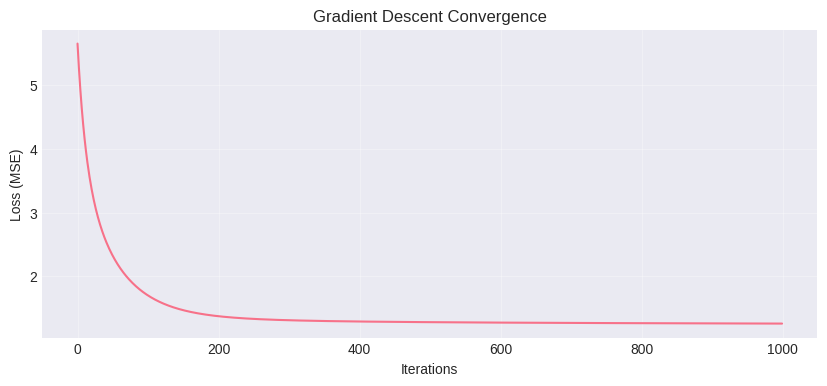

In [ ]:
print("="*60)
print("⚙️ LINEAR REGRESSION FROM SCRATCH (GRADIENT DESCENT)")
print("="*60)

class LinearRegressionGD:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None
        self.loss_history = []

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        # Gradient Descent
        for iteration in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias

            # Compute gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            # Calculate loss
            loss = np.mean((y_pred - y) ** 2)
            self.loss_history.append(loss)

            if iteration % 200 == 0:
                print(f"Iteration {iteration}: Loss = {loss:.4f}")

        return self

    def predict(self, X):
        return np.dot(X, self.weights) + self.bias

# Train the model
print("\n🔄 TRAINING PROGRESS:")
lr_gd = LinearRegressionGD(learning_rate=0.01, n_iterations=1000)
lr_gd.fit(X_train_reg_scaled, y_train_reg.values)

# Predictions
y_pred_gd = lr_gd.predict(X_test_reg_scaled)

# Evaluation
mse_gd = mean_squared_error(y_test_reg, y_pred_gd)
r2_gd = r2_score(y_test_reg, y_pred_gd)

print(f"\n✅ GRADIENT DESCENT RESULTS:")
print(f"Mean Squared Error: {mse_gd:.4f}")
print(f"R² Score: {r2_gd:.4f}")

# Plot training progress
plt.figure(figsize=(10, 4))
plt.plot(lr_gd.loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss (MSE)')
plt.title('Gradient Descent Convergence')
plt.grid(True, alpha=0.3)
plt.show()

## **PHASE 6: CLASSIFICATION MODELS**

**Cell 11: K-Nearest Neighbors (KNN) Classification**

🎯 K-NEAREST NEIGHBORS (KNN) CLASSIFICATION

🔍 FINDING OPTIMAL K VALUE...


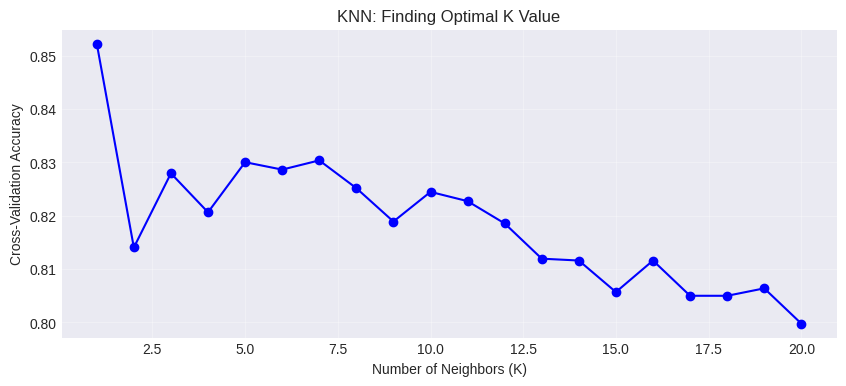

✅ Optimal K value: 1

📊 KNN CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Bad       0.83      0.76      0.79       129
        Good       0.88      0.93      0.90       259
    Moderate       0.85      0.84      0.85       332

    accuracy                           0.86       720
   macro avg       0.85      0.84      0.85       720
weighted avg       0.86      0.86      0.86       720

Accuracy: 0.8583


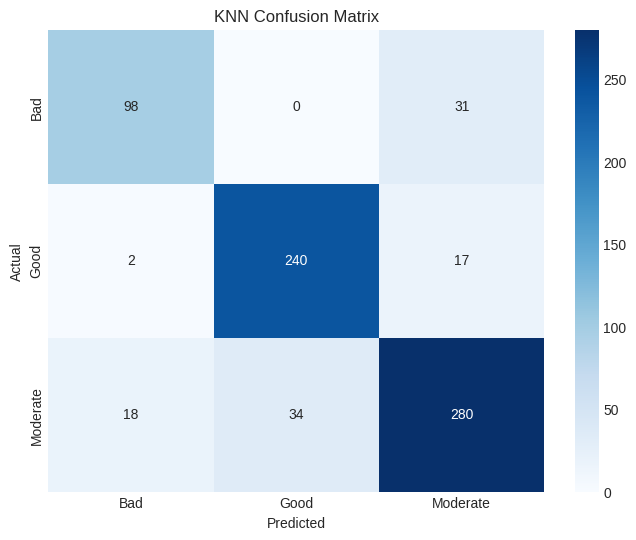

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("🎯 K-NEAREST NEIGHBORS (KNN) CLASSIFICATION")
print("="*60)

# Find optimal k using cross-validation
print("\n🔍 FINDING OPTIMAL K VALUE...")
k_values = list(range(1, 21))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_clf_scaled, y_train_clf, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot accuracy vs k
plt.figure(figsize=(10, 4))
plt.plot(k_values, cv_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Cross-Validation Accuracy')
plt.title('KNN: Finding Optimal K Value')
plt.grid(True, alpha=0.3)
plt.show()

# Get optimal k
optimal_k = k_values[cv_scores.index(max(cv_scores))]
print(f"✅ Optimal K value: {optimal_k}")

# Train with optimal k
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_clf_scaled, y_train_clf)

# Predictions
y_pred_knn = knn_model.predict(X_test_clf_scaled)
y_pred_knn_proba = knn_model.predict_proba(X_test_clf_scaled)

# Evaluation
accuracy_knn = accuracy_score(y_test_clf, y_pred_knn)
print(f"\n📊 KNN CLASSIFICATION REPORT:")
print(classification_report(y_test_clf, y_pred_knn))
print(f"Accuracy: {accuracy_knn:.4f}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test_clf, y_pred_knn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues',
            xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title('KNN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Cell 12: Logistic Regression Classification**

📊 LOGISTIC REGRESSION CLASSIFICATION

📊 LOGISTIC REGRESSION CLASSIFICATION REPORT:
              precision    recall  f1-score   support

         Bad       0.94      0.80      0.86       129
        Good       0.84      0.86      0.85       259
    Moderate       0.82      0.86      0.84       332

    accuracy                           0.85       720
   macro avg       0.87      0.84      0.85       720
weighted avg       0.85      0.85      0.85       720

Accuracy: 0.8472


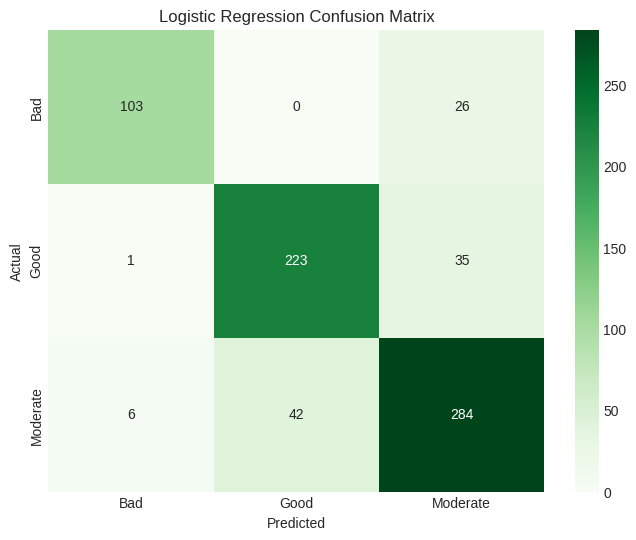

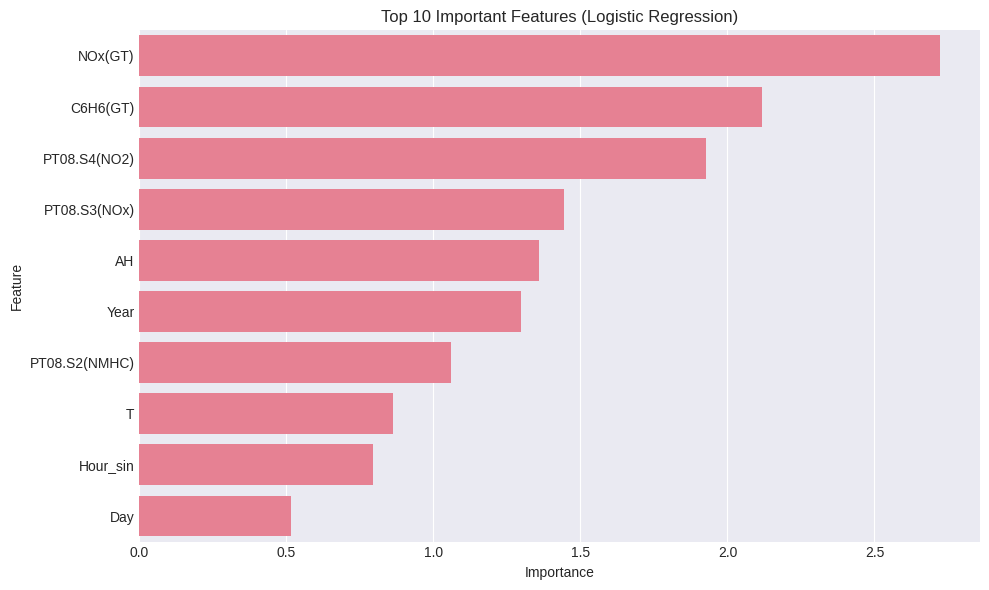

In [ ]:
from sklearn.linear_model import LogisticRegression

print("="*60)
print("📊 LOGISTIC REGRESSION CLASSIFICATION")
print("="*60)

# Train Logistic Regression with hyperparameter tuning
logreg_model = LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr')
logreg_model.fit(X_train_clf_scaled, y_train_clf)

# Predictions
y_pred_logreg = logreg_model.predict(X_test_clf_scaled)
y_pred_logreg_proba = logreg_model.predict_proba(X_test_clf_scaled)

# Evaluation
accuracy_logreg = accuracy_score(y_test_clf, y_pred_logreg)
print("\n📊 LOGISTIC REGRESSION CLASSIFICATION REPORT:")
print(classification_report(y_test_clf, y_pred_logreg))
print(f"Accuracy: {accuracy_logreg:.4f}")

# Confusion Matrix
cm_logreg = confusion_matrix(y_test_clf, y_pred_logreg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logreg, annot=True, fmt='d', cmap='Greens',
            xticklabels=logreg_model.classes_, yticklabels=logreg_model.classes_)
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
if hasattr(logreg_model, 'coef_'):
    feature_importance = pd.DataFrame({
        'Feature': features,
        'Importance': np.abs(logreg_model.coef_[0])
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Important Features (Logistic Regression)')
    plt.tight_layout()
    plt.show()

# **PHASE 7: MODEL COMPARISON & ADVANCED ANALYSIS**

**Cell 13: Model Comparison Visualization**

🏆 MODEL PERFORMANCE COMPARISON

📋 PERFORMANCE SUMMARY:
              Model      RMSE  R²/Accuracy
  Linear Regression  1.067416     0.702632
   Gradient Descent   1.09987     0.684274
                KNN       N/A     0.858333
Logistic Regression       N/A     0.847222


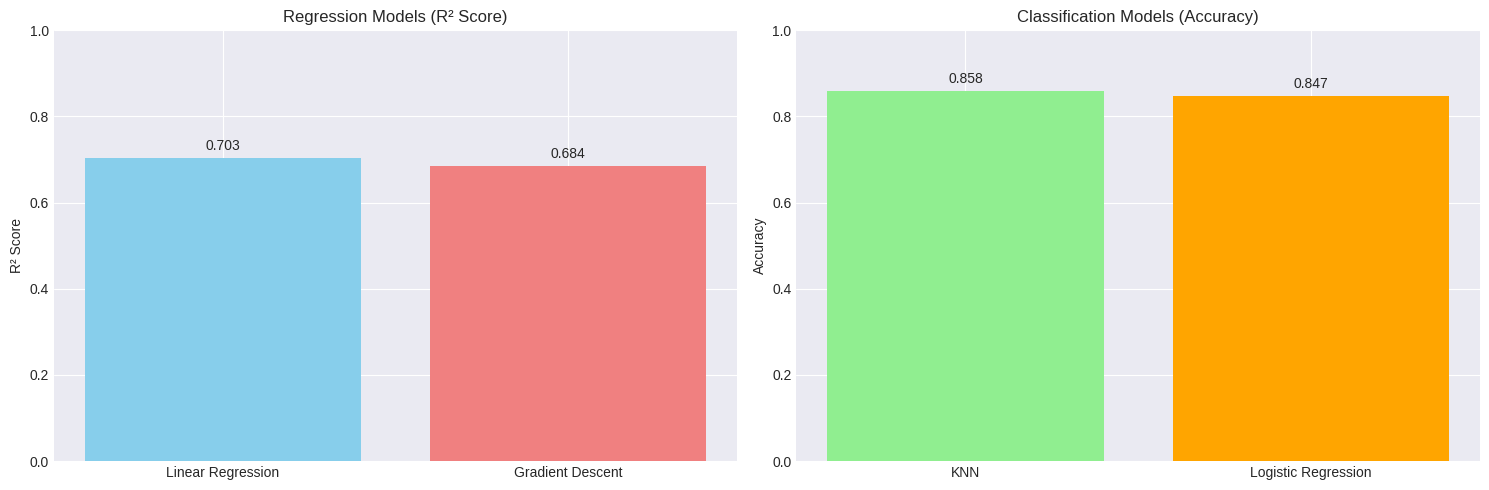

In [ ]:
print("="*60)
print("🏆 MODEL PERFORMANCE COMPARISON")
print("="*60)

# Collect results
results = {
    'Model': ['Linear Regression', 'Gradient Descent', 'KNN', 'Logistic Regression'],
    'RMSE': [np.sqrt(mse_lr), np.sqrt(mse_gd), 'N/A', 'N/A'],
    'R²/Accuracy': [r2_lr, r2_gd, accuracy_knn, accuracy_logreg]
}

results_df = pd.DataFrame(results)
print("\n📋 PERFORMANCE SUMMARY:")
print(results_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Regression models comparison
axes[0].bar(['Linear Regression', 'Gradient Descent'], [r2_lr, r2_gd], color=['skyblue', 'lightcoral'])
axes[0].set_title('Regression Models (R² Score)')
axes[0].set_ylabel('R² Score')
axes[0].set_ylim([0, 1])
for i, v in enumerate([r2_lr, r2_gd]):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center')

# Classification models comparison
axes[1].bar(['KNN', 'Logistic Regression'], [accuracy_knn, accuracy_logreg], color=['lightgreen', 'orange'])
axes[1].set_title('Classification Models (Accuracy)')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim([0, 1])
for i, v in enumerate([accuracy_knn, accuracy_logreg]):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# **PHASE 8: PROJECT Models Save and Export Results**

**Cell 14: Save Models and Export Results**

In [ ]:
from IPython.display import HTML
import joblib
import os

print("="*60)
print("💾 SAVING MODELS AND RESULTS")
print("="*60)

# Create directory for saving
save_dir = '/content/drive/MyDrive/AtmoSense/Models'
os.makedirs(save_dir, exist_ok=True)

# Save models
joblib.dump(lr_model, f'{save_dir}/linear_regression_model.pkl')
joblib.dump(knn_model, f'{save_dir}/knn_model.pkl')
joblib.dump(logreg_model, f'{save_dir}/logistic_regression_model.pkl')
joblib.dump(scaler, f'{save_dir}/scaler.pkl')

# Save results to CSV
results_df.to_csv(f'{save_dir}/model_results.csv', index=False)

# Save cleaned dataset
clean_df.to_csv(f'{save_dir}/cleaned_air_quality.csv', index=False)

# Display messages with larger font size using HTML
display(HTML(f"<p style='font-size:16px;'><b>All models and results saved successfully!</b></p>"))
display(HTML(f"<p style='font-size:16px;'><b>Location: {save_dir}</b></p>"))
display(HTML(f"<p style='font-size:16px;'>{"="*60}</p>"))
display(HTML(f"<p style='font-size:16px;'><b>PROJECT COMPLETED SUCCESSFULLY</b></p>"))
display(HTML(f"<p style='font-size:16px;'>{"="*60}</p>"))
display(HTML(f"<p style='font-size:16px;'><b>\nThank you for using AtmoSense Air Quality Prediction System</b></p>"))

💾 SAVING MODELS AND RESULTS
